In [39]:
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from pandarallel import pandarallel
from matplotlib import pyplot as plt

from reviews.config import processed_data_dir
from reviews.utils import flat_sentence_tokens, preprocess_df, find_tokens_df

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Prepare Data

In [40]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "products_reviews.json.gz", orient="records"
)

reviews_df["summary"] = reviews_df["summary"].astype("string")
reviews_df["text"] = reviews_df["text"].astype("string")

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28983 entries, 0 to 28982
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             28983 non-null  object        
 1   overall          28983 non-null  int64         
 2   reviewerID       28983 non-null  object        
 3   summary          28983 non-null  string        
 4   text             28983 non-null  string        
 5   timestamp        28983 non-null  datetime64[ns]
 6   vote             28983 non-null  int64         
 7   brand            28983 non-null  object        
 8   category         28983 non-null  object        
 9   description      28139 non-null  object        
 10  imageURLHighRes  24005 non-null  object        
 11  price            18830 non-null  float64       
 12  title            28983 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7), string(2)
memory usage: 3.1+ MB


In [41]:
def tokens_counters(tokens_raw, tokens_lemma, tokens_stem):
    # flat sentence tokens
    tokens_raw = flat_sentence_tokens(tokens_raw)
    tokens_lemma = flat_sentence_tokens(tokens_lemma)
    tokens_stem = flat_sentence_tokens(tokens_stem)

    # counters
    c_raw = Counter(tokens_raw)
    c_lemma = Counter(tokens_lemma)
    c_stem = Counter(tokens_stem)

    return {
        "Raw": c_raw,
        "Lemmatization": c_lemma,
        "Stemming": c_stem,
    }

In [42]:
def plot_tokens(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex="all")
    for i, (title, counter) in enumerate(counters_dict.items()):
        data = pd.DataFrame(counter.most_common(30))

        data[1] = data[1] / sum(counter.values())

        sns.barplot(y=data[0], x=data[1], ax=ax[i])

        ax[i].set_title(title)
        ax[i].set_ylabel("Tokens")
        ax[i].set_xlabel("Frequency")

    fig.tight_layout()

In [43]:
def plot_tokens_wordcloud(counters_dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    for i, (title, counter) in enumerate(counters_dict.items()):
        wc = WordCloud(
            collocations=False,
            prefer_horizontal=0.6,
            width=800,
            height=400,
            background_color="white",
        )
        wc.fit_words(counter)

        ax[i].imshow(wc.to_image())
        ax[i].set_title(title)
        ax[i].grid(False)
        ax[i].axis("off")

    fig.tight_layout()

# Summary Tokens

In [44]:
summary_raw = preprocess_df(
    reviews_df, field="summary", normalize="raw", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

5265 rare words found of which 11 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 1.64%


In [45]:
summary_lemma = preprocess_df(
    reviews_df, field="summary", normalize="lemmatization", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

4463 rare words found of which 10 are seeds.
1 common words found of which 0 are seeds.
Common: {'star'}
Empty Docs: 22.42%


In [46]:
summary_stem = preprocess_df(
    reviews_df, field="summary", normalize="stemming", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

3810 rare words found of which 8 are seeds.
1 common words found of which 0 are seeds.
Common: {'star'}
Empty Docs: 22.24%


In [47]:
summary_counters = tokens_counters(
    summary_raw["tokens"], summary_lemma["tokens"], summary_stem["tokens"]
)

for (title, counter) in summary_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 1954
Lemmatization Tokens: 1730
Stemming Tokens: 1678


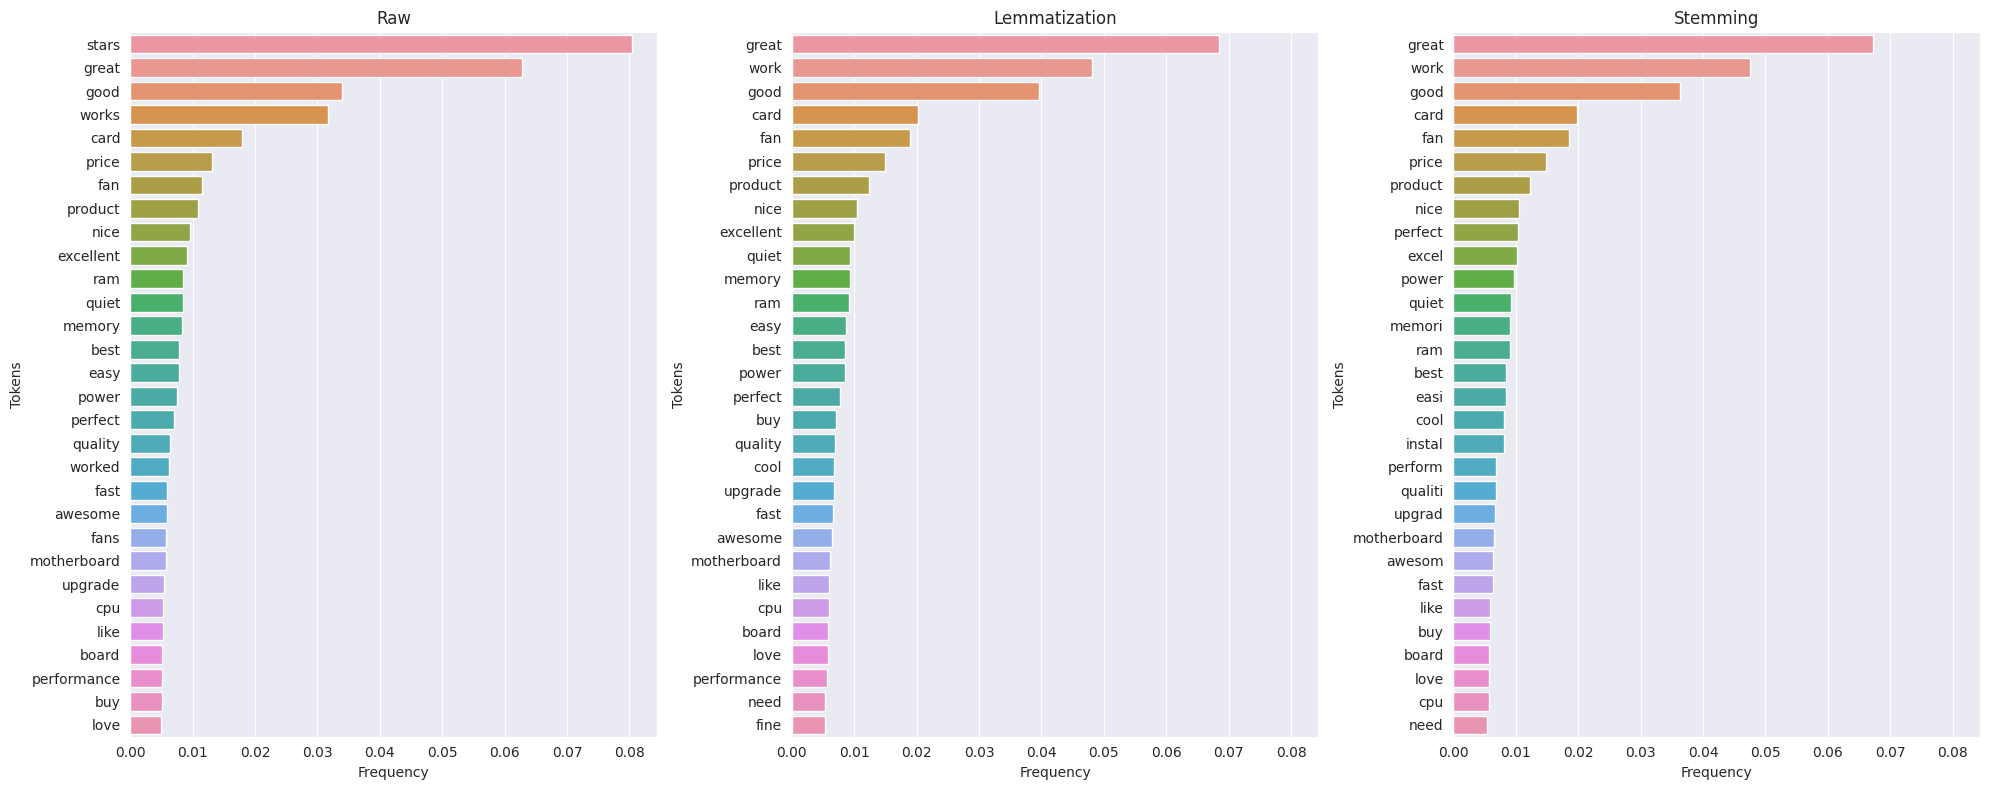

In [48]:
plot_tokens(summary_counters)

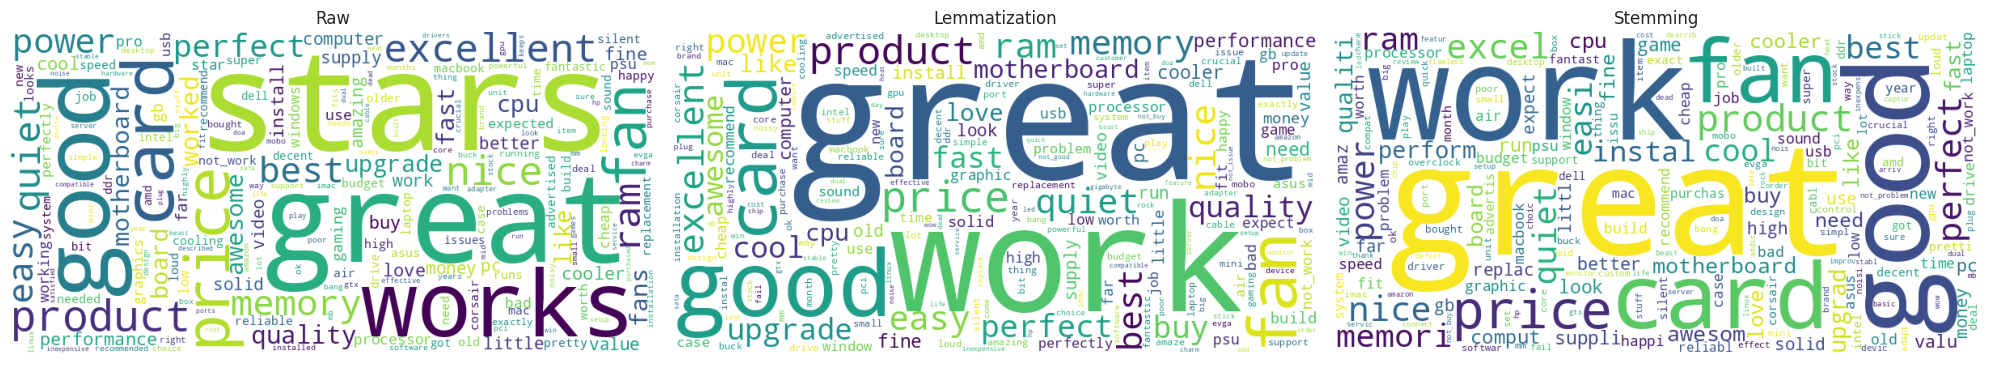

In [49]:
plot_tokens_wordcloud(summary_counters)

# Text Tokens

In [50]:
text_raw = preprocess_df(
    reviews_df, field="text", normalize="raw", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

19740 rare words found of which 0 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 0.10%


In [51]:
text_lemma = preprocess_df(
    reviews_df, field="text", normalize="lemmatization", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

16688 rare words found of which 0 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 0.10%


In [52]:
text_stem = preprocess_df(
    reviews_df, field="text", normalize="stemming", out_dir=processed_data_dir, **dict(t1=0.9, t2=4),
)

13145 rare words found of which 0 are seeds.
0 common words found of which 0 are seeds.
Common: set()
Empty Docs: 0.10%


In [53]:
text_counters = tokens_counters(
    text_raw["tokens"], text_lemma["tokens"], text_stem["tokens"]
)

for (title, counter) in text_counters.items():
    print(f"{title} Tokens:", len(counter.items()))

Raw Tokens: 10716
Lemmatization Tokens: 8504
Stemming Tokens: 7488


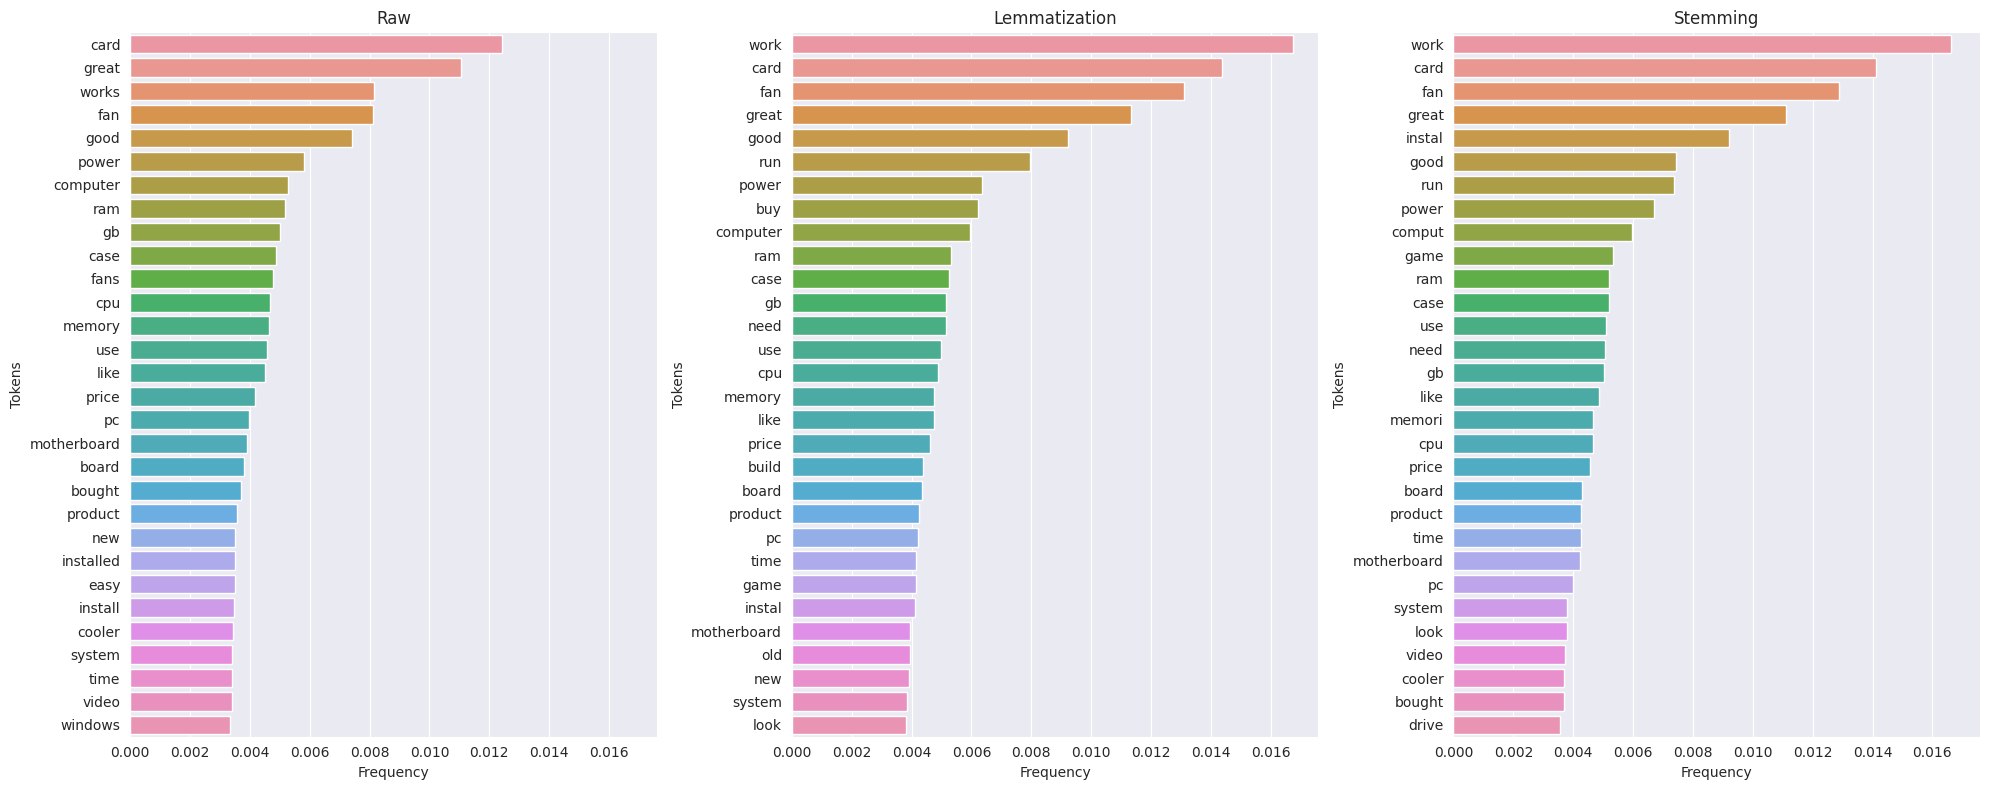

In [54]:
plot_tokens(text_counters)

# Tokens Analysis


In [56]:
def tokens_statistics(tokens):
    from itertools import chain

    n_sentences = tokens.apply(len)
    n_tokens = tokens.apply(lambda x: list(chain.from_iterable(x))).apply(len)

    one_token = tokens[n_tokens == 1].apply(lambda x: list(chain.from_iterable(x)))
    most_common_one_tokens = Counter([y for x in one_token for y in x]).most_common(10)

    print(f"[Sentences] Min: {n_sentences.min()}, Mean: {n_sentences.mean():.2f}, Max: {n_sentences.max()}")
    print(f"[Tokens] Min: {n_tokens.min()}, Mean: {n_tokens.mean():.2f}, Max: {n_tokens.max()}")
    print("")

    print(f"#Reviews with 0 tokens: {len(n_tokens[n_tokens == 0])} ({len(n_tokens[n_tokens == 0]) / len(n_tokens) * 100:.0f}%)")
    print(f"#Reviews with 1 token: {len(n_tokens[n_tokens == 1])} ({len(n_tokens[n_tokens == 1]) / len(n_tokens) * 100:.0f}%)")
    print("Most Common 1 Token:", set(map(lambda x: x[0], most_common_one_tokens)))

In [57]:
tokens_statistics(text_lemma["tokens"])

[Sentences] Min: 0, Mean: 4.06, Max: 124
[Tokens] Min: 0, Mean: 25.22, Max: 1296

#Reviews with 0 tokens: 30 (0%)
#Reviews with 1 token: 1388 (5%)
Most Common 1 Token: {'great', 'job', 'ok', 'nice', 'good', 'excellent', 'perfect', 'work', 'expect', 'advertised'}


In [58]:
tokens_statistics(text_stem["tokens"])

[Sentences] Min: 0, Mean: 4.07, Max: 125
[Tokens] Min: 0, Mean: 25.67, Max: 1302

#Reviews with 0 tokens: 28 (0%)
#Reviews with 1 token: 1373 (5%)
Most Common 1 Token: {'great', 'excel', 'ok', 'nice', 'good', 'perfect', 'work', 'describ', 'thank', 'expect'}


In [59]:
text_lemma_skip = preprocess_df(
    reviews_df, field="text", normalize="lemmatization", out_dir=processed_data_dir, **{"skip": True}
)

text_stem_skip = preprocess_df(
    reviews_df, field="text", normalize="stemming", out_dir=processed_data_dir, **{"skip": True}
)

Empty Docs: 0.06%
Empty Docs: 0.05%


In [60]:
print("Lemmatization\n")

for t1 in {0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99}:
    out = find_tokens_df(text_lemma_skip["tokens"], normalization='lemmatization', **dict(t1=t1))
    print({"T1": t1, "Common": list(out[0])})

print()
for t2 in {2, 3, 4, 5}:
    out = find_tokens_df(text_lemma_skip["tokens"], normalization='lemmatization', **dict(t2=t2))
    print({"T2": t2, "Rare": len(out[1])})

Lemmatization

{'T1': 0.3, 'Common': ['work']}
{'T1': 0.4, 'Common': []}
{'T1': 0.8, 'Common': []}
{'T1': 0.5, 'Common': []}
{'T1': 0.7, 'Common': []}
{'T1': 0.9, 'Common': []}
{'T1': 0.95, 'Common': []}
{'T1': 0.99, 'Common': []}

{'T2': 2, 'Rare': 11819}
{'T2': 3, 'Rare': 15011}
{'T2': 4, 'Rare': 16688}
{'T2': 5, 'Rare': 17697}


In [61]:
print("Stemming")

for t1 in {0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99}:
    out = find_tokens_df(text_stem_skip["tokens"], normalization='stemming', **dict(t1=t1))
    print({"T1": t1, "Common": list(out[0])})

print()
for t2 in {2, 3, 4, 5}:
    out = find_tokens_df(text_stem_skip["tokens"], normalization='stemming', **dict(t2=t2))
    print({"T2": t2, "Rare": len(out[1])})

Stemming
{'T1': 0.3, 'Common': ['work']}
{'T1': 0.4, 'Common': ['work']}
{'T1': 0.8, 'Common': []}
{'T1': 0.5, 'Common': []}
{'T1': 0.7, 'Common': []}
{'T1': 0.9, 'Common': []}
{'T1': 0.95, 'Common': []}
{'T1': 0.99, 'Common': []}

{'T2': 2, 'Rare': 9269}
{'T2': 3, 'Rare': 11833}
{'T2': 4, 'Rare': 13145}
{'T2': 5, 'Rare': 13983}
